# Image generation for Sheep Detection

In this notebook we generate new images based on old images by extracting sheep from a image with sheep and randomly rotate and place them on a new image.

In [1]:
%pip install opencv-python pandas numpy matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from typing import List, Tuple

In [ ]:
ROOT_FOLDER = ".."
DATASET_FOLDER = f"{ROOT_FOLDER}/dataset"
ENHANCED_IMAGE_FOLDER = f"{DATASET_FOLDER}/images/enhanced"
AUGMENTED_IMAGE_FOLDER = f"{DATASET_FOLDER}/images/augmented"

# Augment images

To be able to create more images we can augment the images by cutting the sheep from one image and to paste them on an empty background on random positions.

# Loading images

In [59]:
SHEEP_IMAGE_NAME = "DJI_20240125160538_0008_T.JPG" 
BACKGROUND_IMAGE_NAME = "DJI_20240125160808_0083_T.JPG"

In [60]:
def load_image(path: str) -> np.ndarray:
    """Load an image in grayscale from a file path."""
    image = cv2.imread(path)
    if image is None:
        raise FileNotFoundError(f"Image not found: {path}")
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image

In [78]:
def plot_images(images: list, normalize: bool = False):
    """
    Visually display images using matplotlib.
    
    Parameters:
        normalize (bool): If True, sets vmin/vmax to show noise more clearly.
    """
    fig, axes = plt.subplots(1, len(images), figsize=(5 * len(images), 5))

    if len(images) == 1:
        axes = [axes]

    for ax, image, idx in zip(axes, images, range(1, len(images) + 1)):
        if normalize:
            ax.imshow(image, cmap='gray', vmin=0, vmax=255)
        else:
            ax.imshow(image, cmap='gray')
        ax.set_title(f'Image {idx}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

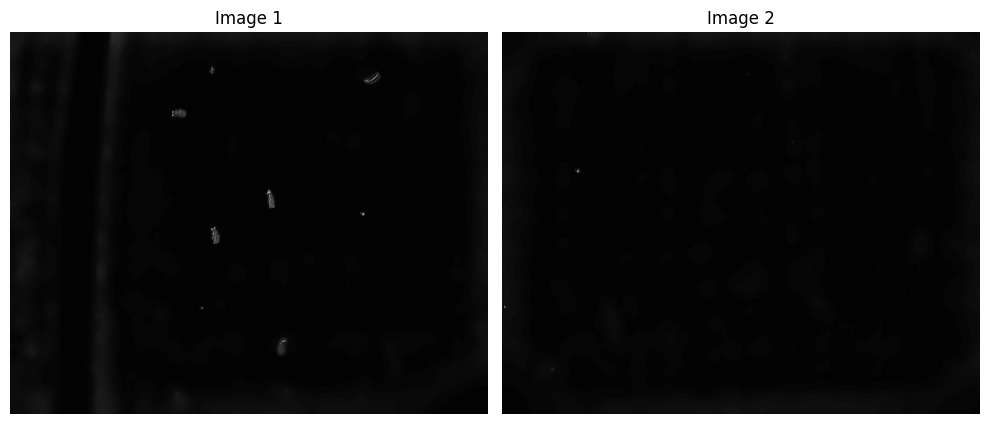

In [79]:
SHEEP_IMAGE = load_image(os.path.join(ENHANCED_IMAGE_FOLDER, SHEEP_IMAGE_NAME))
BACKGROUND_IMAGE = load_image(os.path.join(ENHANCED_IMAGE_FOLDER, BACKGROUND_IMAGE_NAME))

plot_images([SHEEP_IMAGE, BACKGROUND_IMAGE], normalize=True)

# Load annotations

In [64]:
def load_annotations(file_path: str) -> pd.DataFrame:
    """Load bounding box annotations from an Excel file into a DataFrame."""
    df = pd.read_excel(file_path)
    # Expect columns: image_name, bbox_x, bbox_y, bbox_width, bbox_height
    required_cols = {"image_name", "bbox_x", "bbox_y", "bbox_width", "bbox_height"}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"Annotation file missing required columns: {required_cols}")
    return df


ANNOTATIONS_FILE = f"{DATASET_FOLDER}/annotations.xlsx"
sheep_annotations = load_annotations(ANNOTATIONS_FILE)
sheep_annotations.head()

,bbox_x,bbox_y,bbox_width,bbox_height,image_name,image_width,image_height
0,187,68,30,24,DJI_20240125160524_0001_T.JPG,640,512
1,229,29,23,28,DJI_20240125160524_0001_T.JPG,640,512
2,208,21,24,34,DJI_20240125160524_0001_T.JPG,640,512
3,160,1,19,33,DJI_20240125160524_0001_T.JPG,640,512
4,170,10,29,26,DJI_20240125160524_0001_T.JPG,640,512


To be able to know what sheep to cut and where it is we need to create a function which gives us the bounding boxes of one image.

In [65]:
def get_bounding_boxes(image_name: str, df: pd.DataFrame) -> List[Tuple[int, int, int, int]]:
    """Return all bounding boxes (x,y,w,h) for a given image name from the annotations DataFrame."""
    rows = df[df['image_name'] == image_name]
    boxes = [(int(r['bbox_x']), int(r['bbox_y']), int(r['bbox_width']), int(r['bbox_height'])) 
            for _, r in rows.iterrows()]
    return boxes

sheep_bounding_boxes = get_bounding_boxes(SHEEP_IMAGE_NAME, sheep_annotations)
sheep_bounding_boxes

[(469, 52, 34, 25),
 (208, 101, 33, 16),
 (340, 204, 17, 38),
 (263, 255, 22, 31),
 (354, 401, 21, 37)]

Now that we have the bounding boxes sheeps can be cut out.

In [85]:
def plot_sheep(sheep):
    bg = np.zeros((64, 64), dtype=sheep.dtype)
    h, w = sheep.shape
    y, x = (64 - h) // 2, (64 - w) // 2
    bg[y:y+h, x:x+w] = sheep
    plt.figure(figsize=(2, 2))
    plt.imshow(bg, cmap='gray')
    plt.axis('off')
    plt.show()

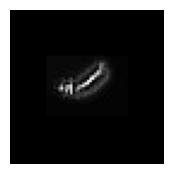

In [86]:
def cut_out_object(image: np.ndarray, box: Tuple[int, int, int, int]) -> np.ndarray:
    """Crop the region defined by the bounding box from the image."""
    x, y, w, h = box
    obj = image[y:y+h, x:x+w].copy()
    # Optionally, to better isolate the sheep, one could set non-sheep pixels to black using a mask.
    # (This would require knowing which pixels are sheep vs background; not done here due to no segmentation mask.)
    return obj

cut_out_sheep = cut_out_object(SHEEP_IMAGE, sheep_bounding_boxes[0])
plot_sheep(cut_out_sheep)

To further create more unique images we need to be able to rotate the sheep and background images asswell.

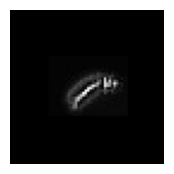

In [87]:
def rotate_image(image: np.ndarray, angle: float) -> np.ndarray:
    """Rotate an image (with background) by a given angle (in degrees) around its center, keeping same size."""
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, scale=1.0)
    # To prevent clipping, we use the same image size output. (Sheep may have corners cut if rotated a lot.)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_LINEAR, borderValue=(0,0,0))
    return rotated

rotated_sheep = rotate_image(cut_out_sheep, 180)
plot_sheep(rotated_sheep)

Not only the sheep needs to be rotated the bounding box needs to be rotated asswell.

In [ ]:
def rotate_bounding_box(box: Tuple[int, int, int, int], angle: int, img_shape) -> Tuple[int, int, int, int]:
    x, y, w, h = box
    cx, cy = img_shape[1] / 2, img_shape[0] / 2
    corners = np.array([[x, y], [x+w, y], [x, y+h], [x+w, y+h]], dtype=np.float32)
    M = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)
    corners = np.dot(np.hstack((corners, np.ones((4, 1)))), M.T)
    x_min, y_min = corners.min(axis=0)
    x_max, y_max = corners.max(axis=0)
    return int(x_min), int(y_min), int(x_max - x_min), int(y_max - y_min)

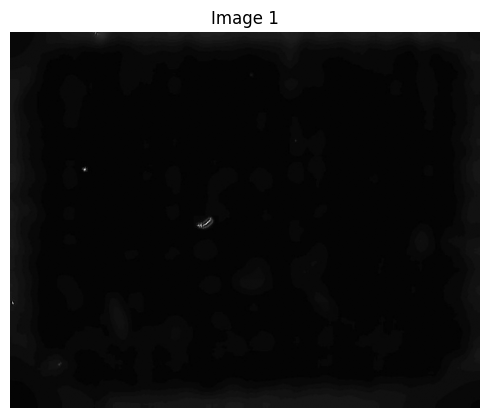

In [90]:
def place_object(background: np.ndarray, obj: np.ndarray, x: int, y: int) -> np.ndarray:
    """Paste the object image onto the background at position (x, y). 
    Non-zero (non-black) pixels of the object will overwrite background."""
    h, w = obj.shape
    if y < 0 or x < 0 or y + h > background.shape[0] or x + w > background.shape[1]:
        return
    mask = obj > 0  # Non-black pixels
    background[y:y+h, x:x+w][mask] = obj[mask]
    return background

new_image = place_object(BACKGROUND_IMAGE.copy(), cut_out_sheep, 250, 250)
plot_images([new_image])

Now we can generate a new image.

In [92]:
def get_random_sheep(sheeps: List[Tuple[int,int,int,int]]):
    """Randomly select a sheep from the list of sheep bounding boxes."""
    return random.choice(sheeps)

def randomly_rotate_sheep(sheep_img: np.ndarray, box: Tuple[int, int, int, int]) -> Tuple[np.ndarray, Tuple[int, int, int, int]]:
    """Cut and randomly rotate the sheep by an angle between 0 and 360 degrees."""
    angle = random.uniform(0, 360)
    sheep_cutout = cut_out_object(sheep_img, box)
    rotated = rotate_image(sheep_cutout, angle)
    rotated_box = rotate_bounding_box(box, angle, sheep_img.shape)
    return rotated, rotated_box

def get_random_position(bg_shape: Tuple[int, int], obj_shape: Tuple[int, int]) -> Tuple[int, int]:
    """Generate a random position (x, y) such that the object fits within the background."""
    max_x = bg_shape[1] - obj_shape[1]
    max_y = bg_shape[0] - obj_shape[0]
    if max_x < 0 or max_y < 0:
        return None  # object too large
    x = random.randint(0, max_x)
    y = random.randint(0, max_y)
    return x, y

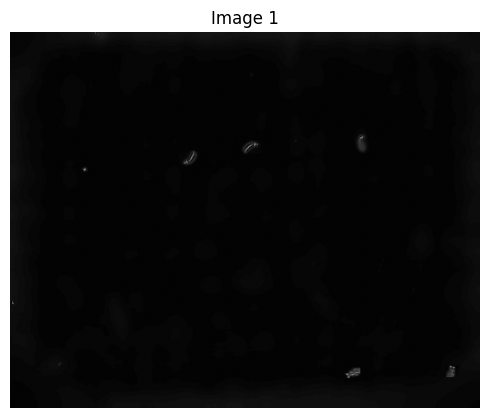

In [96]:
def generate_augmented_image(
    sheep_img: np.ndarray,
    bg_img: np.ndarray,
    boxes: List[Tuple[int, int, int, int]],
    count: int
) -> Tuple[np.ndarray, List[Tuple[int, int, int, int]]]:
    """Compose a new image by pasting `count` randomly selected sheep onto a background."""
    
    result = bg_img.copy()
    new_annots: List[Tuple[int, int, int, int]] = []
    placed = 0
    attempts = 0

    while placed < count and attempts < count * 2:
        attempts += 1

        box = get_random_sheep(boxes)
        rotated_sheep, _ = randomly_rotate_sheep(sheep_img, box)
        h, w = rotated_sheep.shape[:2]

        pos = get_random_position(bg_img.shape, (h, w))
        if pos is None:
            continue
        x, y = pos

        place_object(result, rotated_sheep, x, y)
        new_annots.append((x, y, w, h))
        placed += 1

    return result, new_annots

augmented_image = generate_augmented_image(SHEEP_IMAGE, BACKGROUND_IMAGE, sheep_bounding_boxes, 5)[0]

plot_images([augmented_image], normalize=True)

One image is good but it would be more efficient to generate it in batches.

In [108]:
def display_images_side_by_side(
    images_with_annots: List[Tuple[np.ndarray, List[Tuple[int, int, int, int]]]],
    cols: int = 5,
    draw_boxes: bool = True
):
    """Display a list of grayscale images side by side, optionally with bounding boxes."""
    total = len(images_with_annots)
    rows = (total + cols - 1) // cols
    _, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for ax in axes:
        ax.axis('off')

    for ax, (img, annots) in zip(axes, images_with_annots):
        vis_img = img.copy()
        if draw_boxes:
            for (x, y, w, h) in annots:
                cv2.rectangle(vis_img, (x, y), (x + w, y + h), color=255, thickness=2)
        ax.imshow(vis_img, cmap='gray')

    plt.tight_layout()
    plt.show()

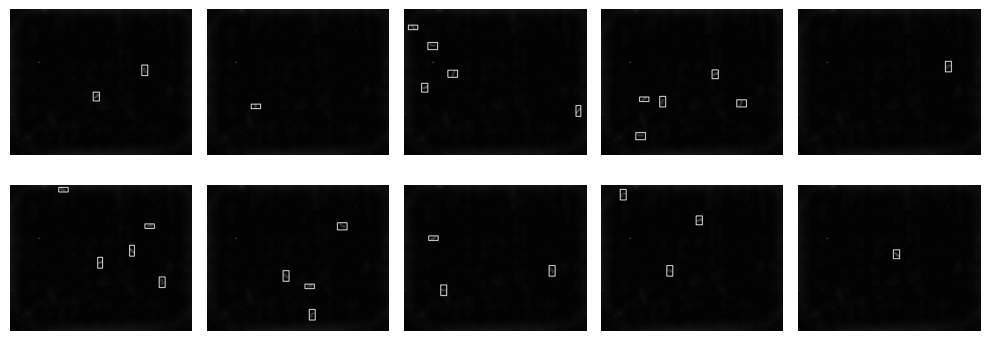

In [109]:
def generate_batch(sheep_img: np.ndarray, bg_img: np.ndarray, boxes: List[Tuple[int,int,int,int]], total_images: int, min_sheep: int = 1, max_sheep: int = 5) -> List[Tuple[np.ndarray, List[Tuple[int,int,int,int]]]]:
    """Generate a batch of `total_images` composite images. Each new image will have a random number of sheep between min_sheep and max_sheep."""
    batch = []
    for _ in range(total_images):
        count = random.randint(min_sheep, max_sheep)
        composite, annots = generate_augmented_image(sheep_img, bg_img, boxes, count)
        batch.append((composite, annots))
    return batch

generated = generate_batch(SHEEP_IMAGE, BACKGROUND_IMAGE, sheep_bounding_boxes, 10, 1, 5)
augmented_images, annotations = zip(*generated)
display_images_side_by_side(generated, cols=5, draw_boxes=True)

Now that the images are generated they can be saved.

In [ ]:
os.makedirs(AUGMENTED_IMAGE_FOLDER, exist_ok=True)
annotations_file = os.path.join(AUGMENTED_IMAGE_FOLDER, "annotations.xlsx")

existing_images = [f for f in os.listdir(AUGMENTED_IMAGE_FOLDER) if f.endswith(".jpg")]
start_idx = len(existing_images)  # how many already present
records = []
for i, (img, boxes) in enumerate(generated, start=start_idx + 1):
    image_name = f"generated_image_{i}.jpg"
    cv2.imwrite(os.path.join(AUGMENTED_IMAGE_FOLDER, image_name), img)
    # record each bounding box in the new image
    for (x, y, w, h) in boxes:
        records.append({
            'image_name': image_name,
            'bbox_x': x,
            'bbox_y': y,
            'bbox_width': w,
            'bbox_height': h
        })
# Append to existing annotations if file exists, otherwise create new
df_new = pd.DataFrame(records)
if os.path.exists(annotations_file):
    df_old = pd.read_excel(annotations_file)
    df_new = pd.concat([df_old, df_new], ignore_index=True)
df_new.to_excel(annotations_file, index=False)
print(f"✅ Saved {len(generated)} augmented images and updated annotations at '{annotations_file}'")

✅ Saved 10 augmented images and updated annotations at '../dataset/images/augmented/annotations.xlsx'
